In [1]:
import os
os.chdir('../..')

In [2]:
import math

import cifar_models
import torch
from torchvision.models import resnet18
from pathlib import Path
from torchvision.datasets import CIFAR10
import torchvision.transforms as TF
from torchmetrics.classification import MulticlassAccuracy
import copy

import os
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as TF
import torch
import torch.nn as nn
import torchvision.models
from tqdm.auto import tqdm

In [3]:
from eXNN.InnerNeuralViz import api

In [4]:
# download repository https://github.com/Med-AI-Lab/industrial-task-casting-defects
# change ind_repo to the root of the downloaded repository
ind_repo = Path('../industrial-task-casting-defects')

In [5]:
data_path = ind_repo / 'casting_512x512'

In [6]:
device = torch.device('cuda:0')

In [7]:
class MyDs(Dataset):
    def __init__(self, pos_files, neg_files, tfm=None):
        self.pos_files = pos_files
        self.neg_files = neg_files
        self.tfm = tfm
    def __len__(self): return len(self.pos_files) + len(self.neg_files)
    def __getitem__(self, i):
        if i < len(self.pos_files):
            pf = data_path / 'def_front' / self.pos_files[i]
            lbl = 1
        else:
            pf = data_path / 'ok_front' / self.neg_files[i - len(self.pos_files)]
            lbl = 0
        image = Image.open(pf)
        if self.tfm is not None:
            image = self.tfm(image)
        return image, lbl
    
def create_datasets():
    pos_files = sorted(os.listdir(data_path / 'def_front'))
    neg_files = sorted(os.listdir(data_path / 'ok_front'))
    np.random.seed(0)
    np.random.shuffle(pos_files)
    np.random.shuffle(neg_files)
    _N = int(len(pos_files) * 0.8)
    trn_pos_files, val_pos_files = pos_files[:_N], pos_files[_N:]
    _N = int(len(neg_files) * 0.8)
    trn_neg_files, val_neg_files = neg_files[:_N], neg_files[_N:]
    _normalize = TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tfm = TF.Compose([TF.Resize((256,256)), TF.ToTensor(), _normalize])
    trn_ds = MyDs(trn_pos_files, trn_neg_files, tfm=tfm)
    val_ds = MyDs(val_pos_files, val_neg_files, tfm=tfm)
    return trn_ds, val_ds

In [8]:
def create_model(num_classes, model_name):
    if model_name.startswith('resnet'):
        # model = getattr(torchvision.models, model_name)(weights='IMAGENET1K_V1')
        model = getattr(torchvision.models, model_name)(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes, bias=True)
    else:
        raise Exception(f'Unsupported model name: `{model_name}`')
    return model

In [9]:
_, test_ds = create_datasets()
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [10]:
# change data_path to the root of the downloaded repository
model = torch.load(ind_repo / 'trained_model.pt', map_location=device)

In [11]:
data, labels = [], []
for batch in test_dl:
    data.append(batch[0])
    labels.append(batch[1])
data = torch.cat(data, dim=0)
labels = torch.cat(labels, dim=0)

In [12]:
model = model.eval()

In [13]:
layers = ['layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']

In [14]:
res = api.VisualizeNetSpace(model, 'umap', data.to(device), layers, labels=labels, chunk_size=128)

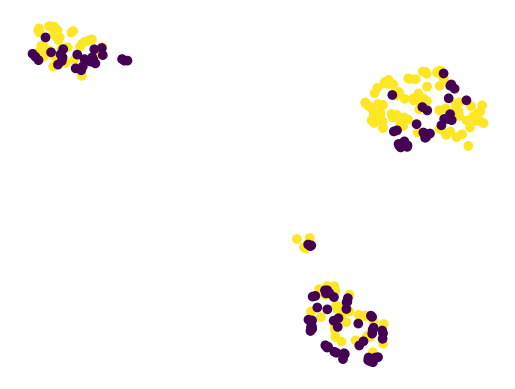

In [15]:
# in input data classes are mixed and can't be separated
res['input']

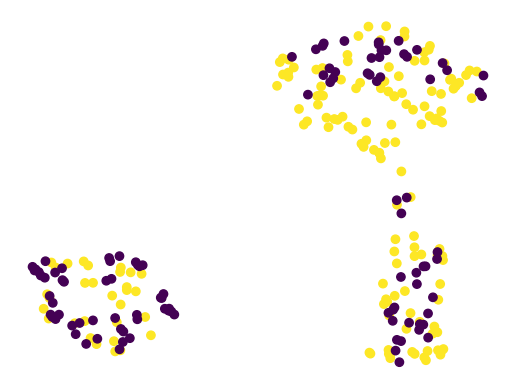

In [16]:
# after first two layers not really better
res['layer2']

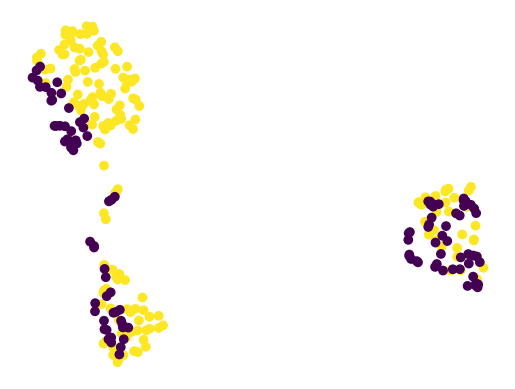

In [17]:
# next layers doesn't really change much
res['layer3']

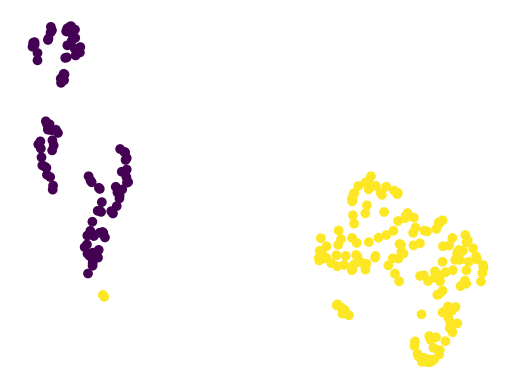

In [18]:
# final conv block separates the data
res['layer4']